In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.models import vgg16
import copy

# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Cutout transformation for data augmentation
class Cutout:
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.0

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img

# Define data transformations with resizing to 224x224 for VGG16
transform_train = transforms.Compose([
    transforms.Resize(224),                     # Resize images to 224x224 for VGG16
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    Cutout(n_holes=1, length=8)
])

transform_test = transforms.Compose([
    transforms.Resize(224),                     # Resize images to 224x224 for VGG16
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset and create DataLoaders
trainset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training data into training and validation sets
train_size = int(0.8 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])

# Create DataLoaders with a default batch size of 128 for initial testing
default_batch_size = 128
train_loader = DataLoader(trainset, batch_size=default_batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=default_batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=default_batch_size, shuffle=False, num_workers=4)

print(f"Number of training samples: {len(trainset)}")
print(f"Number of validation samples: {len(valset)}")
print(f"Number of test samples: {len(testset)}")


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


In [2]:
# Define VGG16 with modified final layer for CIFAR-10
class VGG16ForCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16ForCIFAR10, self).__init__()
        self.model = vgg16(pretrained=False)  # Initialize VGG16 without pre-trained weights
        # Modify the last layer to match CIFAR-10 classes
        self.model.classifier[6] = nn.Linear(4096, num_classes)  # 4096 is the input features to the last FC layer of VGG16

    def forward(self, x):
        return self.model(x)

# Initialize VGG16
model = VGG16ForCIFAR10(num_classes=10).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
# Training function
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Testing function
def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / total
    test_acc = 100. * correct / total
    return test_loss, test_acc, all_preds, all_labels


In [4]:
# Initialize model for initial training
model = VGG16ForCIFAR10(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Initial Training with default batch size
initial_epochs = 10
for epoch in range(initial_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    print(f"Initial Epoch [{epoch+1}/{initial_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Evaluate the model on the test set with default settings
test_loss, test_acc, all_preds, all_labels = test_model(model, test_loader, criterion)
print(f"Initial Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Initial Epoch [1/10], Train Loss: 2.0118, Train Acc: 28.20%, Val Loss: 1.7869, Val Acc: 39.73%
Initial Epoch [2/10], Train Loss: 1.6915, Train Acc: 45.17%, Val Loss: 1.5553, Val Acc: 51.04%
Initial Epoch [3/10], Train Loss: 1.4997, Train Acc: 54.99%, Val Loss: 1.3593, Val Acc: 61.84%
Initial Epoch [4/10], Train Loss: 1.3452, Train Acc: 63.02%, Val Loss: 1.2945, Val Acc: 65.28%
Initial Epoch [5/10], Train Loss: 1.2261, Train Acc: 69.19%, Val Loss: 1.1550, Val Acc: 72.00%
Initial Epoch [6/10], Train Loss: 1.1381, Train Acc: 73.51%, Val Loss: 1.1213, Val Acc: 73.23%
Initial Epoch [7/10], Train Loss: 1.0817, Train Acc: 76.12%, Val Loss: 1.0757, Val Acc: 75.71%
Initial Epoch [8/10], Train Loss: 1.0249, Train Acc: 78.96%, Val Loss: 1.0198, Val Acc: 78.20%
Initial Epoch [9/10], Train Loss: 0.9846, Train Acc: 80.70%, Val Loss: 1.0290, Val Acc: 78.35%
Initial Epoch [10/10], Train Loss: 0.9367, Train Acc: 83.14%, Val Loss: 0.9853, Val Acc: 80.21%
Initial Test Loss: 0.9826, Test Accuracy: 80.39%


In [5]:
# Define hyperparameters to tune
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [64, 128]
weight_decays = [1e-4, 5e-4]
num_epochs = 20
results = []
best_val_accuracy = 0

# Iterate over each combination of hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for weight_decay in weight_decays:
            # Initialize VGG16 model for CIFAR-10
            model = VGG16ForCIFAR10(num_classes=10).to(device)
            criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
            scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

            # Data loaders with current batch size
            train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
            val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)

            for epoch in range(num_epochs):
                train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
                val_loss, val_acc = validate(model, val_loader, criterion)
                scheduler.step()

                # Update best validation accuracy and hyperparameters
                if val_acc > best_val_accuracy:
                    best_val_accuracy = val_acc
                    best_model = copy.deepcopy(model.state_dict())
                    best_hyperparams = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'weight_decay': weight_decay,
                    }

            # Record results
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'weight_decay': weight_decay,
                'val_accuracy': val_acc,
            })
            print(f"LR: {lr}, Batch: {batch_size}, WD: {weight_decay}, Val Acc: {val_acc:.2f}%")

# Print best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparams)
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


LR: 0.1, Batch: 64, WD: 0.0001, Val Acc: 9.73%
LR: 0.1, Batch: 64, WD: 0.0005, Val Acc: 9.73%
LR: 0.1, Batch: 128, WD: 0.0001, Val Acc: 9.73%
LR: 0.1, Batch: 128, WD: 0.0005, Val Acc: 9.73%
LR: 0.01, Batch: 64, WD: 0.0001, Val Acc: 86.52%
LR: 0.01, Batch: 64, WD: 0.0005, Val Acc: 86.16%
LR: 0.01, Batch: 128, WD: 0.0001, Val Acc: 85.51%
LR: 0.01, Batch: 128, WD: 0.0005, Val Acc: 84.91%
LR: 0.001, Batch: 64, WD: 0.0001, Val Acc: 79.59%
LR: 0.001, Batch: 64, WD: 0.0005, Val Acc: 80.32%
LR: 0.001, Batch: 128, WD: 0.0001, Val Acc: 73.62%
LR: 0.001, Batch: 128, WD: 0.0005, Val Acc: 75.92%
Best Hyperparameters:
{'learning_rate': 0.01, 'batch_size': 64, 'weight_decay': 0.0001}
Best Validation Accuracy: 86.52%


Test Loss with Optimized Hyperparameters: 0.8421, Test Accuracy: 86.52%
Classification Report (Optimized):
              precision    recall  f1-score   support

    airplane       0.88      0.92      0.90      1000
  automobile       0.93      0.96      0.94      1000
        bird       0.84      0.79      0.81      1000
         cat       0.74      0.70      0.72      1000
        deer       0.80      0.86      0.83      1000
         dog       0.79      0.81      0.80      1000
        frog       0.87      0.90      0.89      1000
       horse       0.92      0.89      0.90      1000
        ship       0.95      0.92      0.93      1000
       truck       0.93      0.91      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000

Confusion Matrix (Optimized):


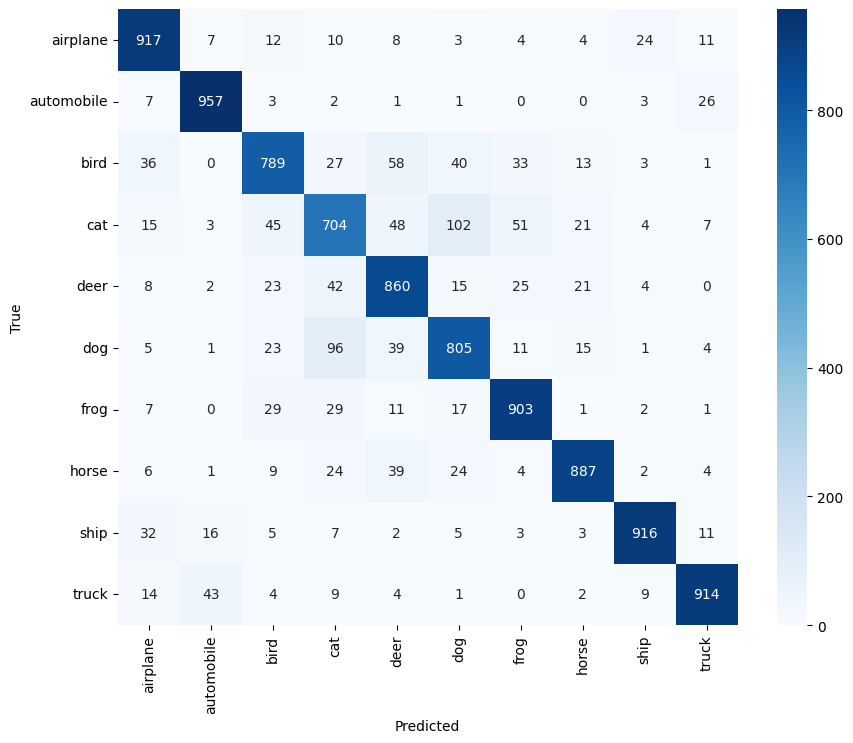

In [6]:
# Load the best model with optimized hyperparameters
model.load_state_dict(best_model)

# Prepare test loader with best batch size
test_loader = DataLoader(testset, batch_size=best_hyperparams['batch_size'], shuffle=False, num_workers=4)

# Evaluate the model on the test set
test_loss, test_acc, all_preds, all_labels = test_model(model, test_loader, criterion)
print(f"Test Loss with Optimized Hyperparameters: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Classification report and confusion matrix
print("Classification Report (Optimized):")
print(classification_report(all_labels, all_preds, target_names=testset.classes))

print("Confusion Matrix (Optimized):")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
